## 1. Подготовка

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from tqdm import notebook, tqdm
import datetime as dt

import nltk
from nltk.corpus import stopwords as nltk_stopwords
from nltk.corpus import wordnet

from sklearn.model_selection import train_test_split, KFold, cross_val_score, ParameterGrid
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import shuffle
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, confusion_matrix

In [2]:
tqdm.pandas()

C:\ProgramData\Anaconda3\lib\site-packages\tqdm\std.py:648: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [3]:
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\albri\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\albri\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### 1.1 Загрузка данных

In [4]:
comments = pd.read_csv('datasets/toxic_comments.csv')
print(comments.info())
comments

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
text     159571 non-null object
toxic    159571 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.4+ MB
None


,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
...,...,...
159566,""":::::And for the second time of asking, when ...",0
159567,You should be ashamed of yourself \n\nThat is ...,0
159568,"Spitzer \n\nUmm, theres no actual article for ...",0
159569,And it looks like it was actually you who put ...,0


Датасет содержит комментарии на английском языке. Пропуски отсутствуют.

### 1.2 Обзор данных

Проверим наличие дубликатов

In [5]:
print('\nДубликаты:', comments.duplicated().sum())


Дубликаты: 0


Дубликаты отсутствуют. Проверим распределение целевого признака

In [6]:
comments['toxic'].value_counts()

0    143346
1     16225
Name: toxic, dtype: int64

Токсичных комментариев в 9 раз меньше, чем обычных. Чтобы модель научилась адекватно опредлять токсичные комментарии, в ходе обучения нужно будет справиться с этим дисбалансом.

Переведем комментарии в нижний регистр

In [7]:
comments['text'] = comments['text'].str.lower()
comments

,text,toxic
0,explanation\nwhy the edits made under my usern...,0
1,d'aww! he matches this background colour i'm s...,0
2,"hey man, i'm really not trying to edit war. it...",0
3,"""\nmore\ni can't make any real suggestions on ...",0
4,"you, sir, are my hero. any chance you remember...",0
...,...,...
159566,""":::::and for the second time of asking, when ...",0
159567,you should be ashamed of yourself \n\nthat is ...,0
159568,"spitzer \n\numm, theres no actual article for ...",0
159569,and it looks like it was actually you who put ...,0


### 1.3 Подготовка комментариев

Очистим текст от чисел и знаков препинания с помощью регулярных выражений

In [8]:
comments['cleared'] = comments['text'].apply(lambda x: ' '.join(re.sub(r'[^a-z \']', ' ', x).split()))
comments

,text,toxic,cleared
0,explanation\nwhy the edits made under my usern...,0,explanation why the edits made under my userna...
1,d'aww! he matches this background colour i'm s...,0,d'aww he matches this background colour i'm se...
2,"hey man, i'm really not trying to edit war. it...",0,hey man i'm really not trying to edit war it's...
3,"""\nmore\ni can't make any real suggestions on ...",0,more i can't make any real suggestions on impr...
4,"you, sir, are my hero. any chance you remember...",0,you sir are my hero any chance you remember wh...
...,...,...,...
159566,""":::::and for the second time of asking, when ...",0,and for the second time of asking when your vi...
159567,you should be ashamed of yourself \n\nthat is ...,0,you should be ashamed of yourself that is a ho...
159568,"spitzer \n\numm, theres no actual article for ...",0,spitzer umm theres no actual article for prost...
159569,and it looks like it was actually you who put ...,0,and it looks like it was actually you who put ...


Лемматизируем комментарии с помощью библиотеки nltk

In [9]:
%%time
wnl = nltk.stem.WordNetLemmatizer()
comments['lemmatized'] = comments['cleared'].progress_apply(lambda x: ' '.join([wnl.lemmatize(w) 
                                                                                for w in nltk.word_tokenize(x)]))
comments

100%|████████████████████████████████████████████████████████████████████████| 159571/159571 [01:46<00:00, 1497.91it/s]


Wall time: 1min 46s


,text,toxic,cleared,lemmatized
0,explanation\nwhy the edits made under my usern...,0,explanation why the edits made under my userna...,explanation why the edits made under my userna...
1,d'aww! he matches this background colour i'm s...,0,d'aww he matches this background colour i'm se...,d'aww he match this background colour i 'm see...
2,"hey man, i'm really not trying to edit war. it...",0,hey man i'm really not trying to edit war it's...,hey man i 'm really not trying to edit war it ...
3,"""\nmore\ni can't make any real suggestions on ...",0,more i can't make any real suggestions on impr...,more i ca n't make any real suggestion on impr...
4,"you, sir, are my hero. any chance you remember...",0,you sir are my hero any chance you remember wh...,you sir are my hero any chance you remember wh...
...,...,...,...,...
159566,""":::::and for the second time of asking, when ...",0,and for the second time of asking when your vi...,and for the second time of asking when your vi...
159567,you should be ashamed of yourself \n\nthat is ...,0,you should be ashamed of yourself that is a ho...,you should be ashamed of yourself that is a ho...
159568,"spitzer \n\numm, theres no actual article for ...",0,spitzer umm theres no actual article for prost...,spitzer umm there no actual article for prosti...
159569,and it looks like it was actually you who put ...,0,and it looks like it was actually you who put ...,and it look like it wa actually you who put on...


Более качественную лемматизацию можно получить, если в `wnl.lemmatize(w)` учитывать части речи с использованием `pos_tag`, но тогда время обработки комментариев катастрофически увеличивается. Пока обойдемся быстрым алгоритмом.

### 1.4 Подготовка выборок

Выделим тестовую выборку объемом 20% от исходного датасета.

In [10]:
data_train, data_test = train_test_split(comments, test_size=0.2, random_state=123)
print('train:', data_train.shape)
print('test:',  data_test.shape)

train: (127656, 4)
test: (31915, 4)


Для более эффективного подбора модели будем использовать кросс-валидацию в рамках всей обучающей выборки. Но чтобы кросс-валидация была корректной, на каждом шаге модель, формирующая параметры, должна обучаться только на обучающей подвыборке. Это же касается и балансировки: балансироваться должна только обучающая подвыборка. Стандартными функциями кросс-валидации библиотеки sklearn реализовать это не получается.  
Введем функцию train_valid_folds, которая подготовит по 5 наборов обучающих и валидационных подвыборок, для формирования признаков будем использовать мешок слов (метод `TfidfVectorizer` библиотеки `sklearn`). Для экономии времении сделаем это один раз для каждого вида балансировки, сохраним получившиеся наборы и в дальнейшем будем обращаться к ним.

In [11]:
def upsample(features, target):
    
    counts = target.value_counts()
    val_most = counts.index[0]
    val_least = counts.index[1]
    repeat = int(np.round(counts[0]/counts[1],0))
    
    target_most = target[target == val_most]
    features_most = features[target == val_most]
    target_least = target[target == val_least]
    features_least = features[target == val_least]
    
    features_upsampled = pd.concat([features_most] + [features_least] * repeat)
    target_upsampled = pd.concat([target_most] + [target_least] * repeat)
    
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)
    return features_upsampled, target_upsampled

In [12]:
def downsample(train_features, train_target, valid_features, valid_target, valid_frac=0, n=0):
    '''
    train_features - 
    train_target - 
    valid_features - 
    valid_target - 
    valid_frac - требуемое соотношение обучающей и валидационной выборки
    n - максимальный суммарный размер обучающией и валидационной выборки
    ''' 
    # расчет имеющегося соотношения признаков
    counts = train_target.value_counts()
    val_most = counts.index[0]
    val_least = counts.index[1]
    fraction = counts[1]/counts[0]
    
    # дополнительно обрезаем выборки (если есть такая необходимость)
    if n:
        if len(train_target) + len(valid_target) > n:
            train_size = int(n*(1-valid_frac)*2/fraction)
            print(train_size)
            train_target = train_target.sample(n=train_size, random_state=12345)
    
    # разделение обучающей выборки по целевому признаку
    train_target_most = train_target[train_target == val_most]
    train_features_most = train_features[train_target == val_most]
    train_target_least = train_target[train_target == val_least]
    train_features_least = train_features[train_target == val_least]

    # downsample обучающей выборки, чтобы сбалансировать признак
    train_features_downsampled = pd.concat([train_features_most.sample(frac=fraction, random_state=12345)] 
                                           + [train_features_least])
    train_target_downsampled = pd.concat([train_target_most.sample(frac=fraction, random_state=12345)] 
                                         + [train_target_least])
    train_features_downsampled, train_target_downsampled = shuffle(train_features_downsampled, 
                                                                   train_target_downsampled, random_state=12345)    
    
    # обрезка валидационной выборки, чтобы соблюсти соотношение обучающей и валидационной (если есть такая необходимость)
    if valid_frac or n:
        if not valid_frac:
            valid_frac = len(valid_target) / len(train_target)
        valid_size = int(valid_frac*len(train_target_downsampled))
        valid_features = valid_features.sample(n=valid_size, random_state=12345)
        valid_target = valid_target.sample(n=valid_size, random_state=12345)

    return train_features_downsampled, train_target_downsampled, valid_features, valid_target

In [13]:
stopwords = set(nltk_stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=stopwords)

def train_valid_folds(features, target, folds=5, balance=None):

    tt = []
    tf = []
    vt = []
    vf = []
    kf = KFold(n_splits=folds)
    
    for train_index, test_index in kf.split(features):
        # разбиение на обучающую и валидационную подвыборки
        train_corpus = features.iloc[train_index]
        valid_corpus = features.iloc[test_index]
        train_target = target.iloc[train_index]
        valid_target = target.iloc[test_index]

        if balance=='upsample':
            train_corpus, train_target = upsample(train_corpus, train_target)
        if balance=='downsample':
            train_corpus, train_target, valid_corpus, valid_target = downsample(train_corpus, train_target, valid_corpus, valid_target)
        
        # создание признаков обучающей подвыборки
        train_features = count_tf_idf.fit_transform(train_corpus.values.astype('U'))
        # создание признаков валидационной подвыборки
        valid_features = count_tf_idf.transform(valid_corpus.values.astype('U'))

        tf.append(train_features)
        tt.append(train_target)
        vf.append(valid_features)
        vt.append(valid_target)

    # отображение размерности для проверки
    for i in range(folds):
        print(i, tf[i].shape, tt[i].shape, vf[i].shape, vt[i].shape)
    return tf, tt, vf, vt

Исходная (несбалансированная) выборка

In [14]:
train_valid = train_valid_folds(data_train['lemmatized'], data_train['toxic'])

0 (102124, 121661) (102124,) (25532, 121661) (25532,)
1 (102125, 122045) (102125,) (25531, 122045) (25531,)
2 (102125, 121783) (102125,) (25531, 121783) (25531,)
3 (102125, 121707) (102125,) (25531, 121707) (25531,)
4 (102125, 122262) (102125,) (25531, 122262) (25531,)


Увеличенная выборка

In [15]:
train_valid_upsampled = train_valid_folds(data_train['lemmatized'], data_train['toxic'], balance='upsample')

0 (185876, 121661) (185876,) (25532, 121661) (25532,)
1 (185941, 122045) (185941,) (25531, 122045) (25531,)
2 (185085, 121783) (185085,) (25531, 121783) (25531,)
3 (186005, 121707) (186005,) (25531, 121707) (25531,)
4 (186021, 122262) (186021,) (25531, 122262) (25531,)


Уменьшенная выборка

In [16]:
train_valid_downsampled = train_valid_folds(data_train['lemmatized'], data_train['toxic'], balance='downsample')

0 (20938, 44024) (20938,) (25532, 44024) (25532,)
1 (20954, 43742) (20954,) (25531, 43742) (25531,)
2 (20740, 43332) (20740,) (25531, 43332) (25531,)
3 (20970, 42952) (20970,) (25531, 42952) (25531,)
4 (20974, 43873) (20974,) (25531, 43873) (25531,)


Из-за большого дисбаланса тестовые подвыборки очень сильно сократились и стали меньше, чем валидационные. Также значительно уменьшилось кол-во признаков. Получить хороший результат в такой ситуации вряд ли удастся, нужно изменить алгоритм уменьшения выборки. Сейчас проверим как есть, новый алгоритм попробую реализовать после завершения проекта.

Стандартизацию признаков выполнять не нужно, т.к. tf_idf по определению находится в пределах от 0 до 1

## 2. Обучение

Заготовка таблицы для сравнения результатов разных моделей

In [17]:
result_table = pd.DataFrame()

Для подбора моделей введем функцию paramCV, которая будет выполнять кросс-валидацию для набора гиперпараметров, используя ранее подготовленнй набор подвыборок. Для отображения результатов в виде графика или тепловой карты введем функции plot_line и plot_heatmap.

In [18]:
def plot_line(x, y, labels='', title='', xlabel=''):
    '''
    Функция выводит графики зависимости выбранных метрик исследуемой модели от значения гиперпараметра
    Входные параметры:
    - х - значения гиперпараметра
    - results - массив результатов
    - label - название результата (легенда линии)
    - title - название модели (подпись графика)
    - xlabel - название изменяемого гиперпараметра (подпись оси Х)
    - treshold - пороговое значение (прямая на линия на графике, не обязательный параметр)
    '''
    fig, ax = plt.subplots(figsize=(10,4))
    ax.plot(x, y, marker='.')
    ax.grid()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.show()

In [19]:
def plot_heatmap(x1, x2, y, title='', label=['','']):
    '''
    функция выводит график типа "heatmap" зависимости качества исследуемой модели от значений двух гиперпараметров
    х1 - значения гиперпараметра 1
    х2 - значения гиперпараметра 2
    y - значение метрики в виде одномерного массива (результат работы функции GridSearchCV.cv_results_['...'])
    title - название модели (подпись графика)
    label - массив с названиями двух гиперпараметров (подписи осей Х и Y)
    '''
    ysize = len(x1) if len(x1)<16 else 16
    xsize = len(x2) if len(x2)<16 else 16
    fig, ax = plt.subplots(figsize=(xsize,ysize))
    im = ax.imshow(y, cmap='coolwarm')
    plt.title(title)
    
    cax = fig.add_axes([ax.get_position().x1+0.05, ax.get_position().y0, 0.02, ax.get_position().height])
    plt.colorbar(im, cax=cax)

    ax.set_xticks(np.arange(len(x2)))
    ax.set_yticks(np.arange(-0.5,len(x1)))
    ax.set_xticklabels(x2)
    ax.set_yticklabels(x1)
    ax.set_xlabel(label[1])
    ax.set_ylabel(label[0])

    for i in range(len(x1)):
        for j in range(len(x2)):
            text = ax.text(j, i, y[i, j], ha="center", va="center", color="k", fontsize=8)
    plt.show()

In [20]:
def paramCV(data, model, params={}, name=''):
    '''
    кастомная кросс-валидация с перебором параметров (аналог GridSearchCV)
    '''
    # разбор data на набор X и y обучающей и валидационной выборок
    tf = data[0]
    tt = data[1]
    vf = data[2]
    vt = data[3] 
    
    res = []
    grid = ParameterGrid(params)    
    pbar = notebook.tqdm(total=len(grid)*len(tf))
    
    # перебор сетки параметров
    for g in grid:
        model.set_params(**g)
        cv_res = []
        for i in range(len(tf)):
            model.fit(tf[i], tt[i])
            valid_predicted = model.predict(vf[i])
            cv_res.append(f1_score(vt[i], valid_predicted))
            pbar.update()
        res.append(np.mean(cv_res).round(3))
    
    # графики
    params_values = list(params.values())
    params_keys = list(params.keys())
    # линия для одного параметра
    if len(params_keys)==1:
        plot_line(params_values[0], res, title='F1 '+name, xlabel=params_keys[0])
    # тепловая карта для двух параметров
    elif len(params_keys)==2:
        len_p1 = len(params_values[0])
        len_p2 = len(params_values[1])
        res = np.reshape(res, (len_p1, len_p2))              
        plot_heatmap(params_values[0], params_values[1], res, title='F1 '+name, label=params_keys)
    elif len(params_keys)>2:
        print('grid_hparams: can\'t plot result')
    
    # отображение лучшего результата
    print('Best F1:', np.max(res))
    if len(params_keys) > 0:
        best_idx = np.argmax(res)
        print('Best params:', grid[best_idx])

    # запись лучшего результата в таблицу
    if name:
        result_table.loc[name,'F1'] = np.max(res)

### 2.1 Логистическая регрессия

Сначала определимся с решателем, для чего выполним кросс-валидацию на несбалансированной выборке.

In [21]:
%%time
model = LogisticRegression(solver='lbfgs')
paramCV(train_valid, model)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Best F1: 0.725
Wall time: 17 s


In [22]:
%%time
model = LogisticRegression(solver='newton-cg')
paramCV(train_valid, model)

Best F1: 0.725
Wall time: 14 s


In [23]:
%%time
model = LogisticRegression(solver='liblinear')
paramCV(train_valid, model)

Best F1: 0.725
Wall time: 7.33 s


In [24]:
%%time
model = LogisticRegression(solver='sag')
paramCV(train_valid, model)

Best F1: 0.725
Wall time: 9.82 s


Все варианты дают одинаковый результат, но решатель 'liblinear' быстрее остальных. Будем использовать его.

Передаваемые модели данные содержат много парамеров, поэтому большое значение для логистической регрессии приобретает гиперпараметр С - сила регуляции. Проверим результат в зависимости от значения гиперпарамера С для разных способов балансировки.

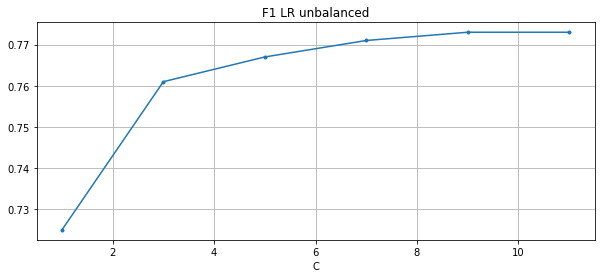

Best F1: 0.773
Best params: {'C': 9}
Wall time: 1min 1s


In [25]:
%%time
model = LogisticRegression(solver='liblinear')
params = {'C': range(1,12,2)}
paramCV(train_valid, model, params, 'LR unbalanced')

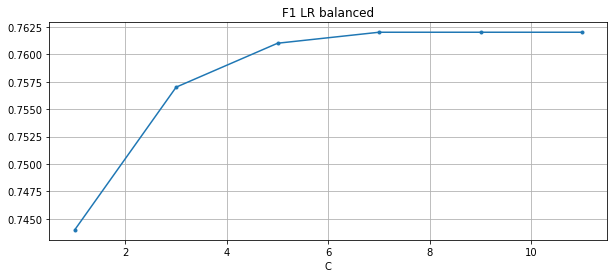

Best F1: 0.762
Best params: {'C': 7}
Wall time: 1min 41s


In [26]:
%%time
model = LogisticRegression(solver='liblinear', class_weight='balanced')
params = {'C': range(1,12,2)}
paramCV(train_valid, model, params, 'LR balanced')

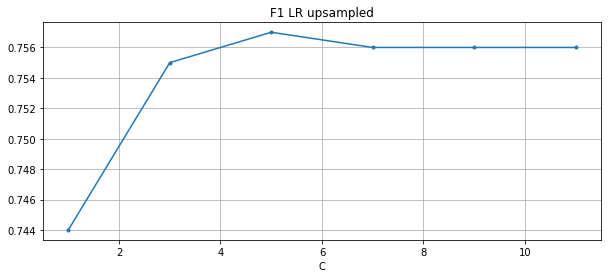

Best F1: 0.757
Best params: {'C': 5}
Wall time: 3min 16s


In [27]:
%%time
model = LogisticRegression(solver='liblinear')
params = {'C': range(1,12,2)}
paramCV(train_valid_upsampled, model, params, 'LR upsampled')

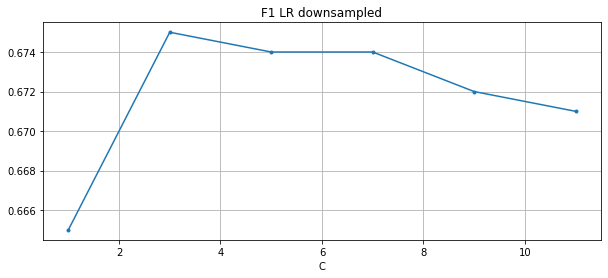

Best F1: 0.675
Best params: {'C': 3}
Wall time: 11.2 s


In [28]:
%%time
model = LogisticRegression(solver='liblinear')
params = {'C': range(1,12,2)}
paramCV(train_valid_downsampled, model, params, 'LR downsampled')

Если сравнивать разные варианты баланисировки при значении С по умолчанию (1), то наблюдаем следующую картину. Внутренняя балансировка модели и увеличение выборки показывают примерно одинаковый результат, который лучше, чем у несбалансированной выборки. При этом балансировка требует дополнительного времени, в случае увеличения выборки - заметного.  
Однако при ослаблении регуляризации (увеличении С) картина меняется. Лучший результат получается несбалансированой выборке: F1=0,771 при С=9, он уже удовлетворяет условию проекта. Внутренняя балансировка модели и увеличение выборки показали результат несколько хуже и при этом потребовали больше времени.  
Уменьшенная выборка, как и ожидалоь, показала наихудший результат. В дальнейшем в проекте нет смысла ее рассматривать.  
Таким образом, оптимальный с точки зрения точности и времени результат для логистической регрессии получается при несбалансированной выборке, решателе liblinear и значении С=9.

In [29]:
result_table

,F1
LR unbalanced,0.773
LR balanced,0.762
LR upsampled,0.757
LR downsampled,0.675


### 2.2 SGD

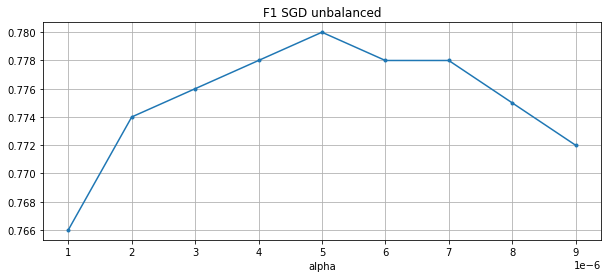

Best F1: 0.78
Best params: {'alpha': 4.9999999999999996e-06}
Wall time: 17.4 s


In [30]:
%%time
model = SGDClassifier(random_state=123)
params = {'alpha': np.arange(0.000001, 0.00001, 0.000001)}
paramCV(train_valid, model, params, 'SGD unbalanced')

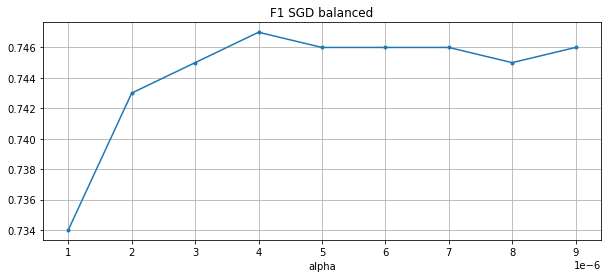

Best F1: 0.747
Best params: {'alpha': 4e-06}
Wall time: 29.5 s


In [31]:
%%time
model = SGDClassifier(class_weight='balanced', random_state=123)
params = {'alpha': np.arange(0.000001, 0.00001, 0.000001)}
paramCV(train_valid, model, params, 'SGD balanced')

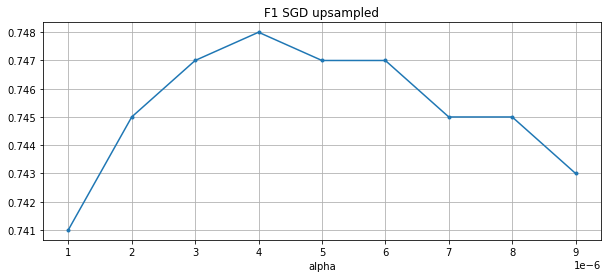

Best F1: 0.748
Best params: {'alpha': 4e-06}
Wall time: 31.6 s


In [32]:
%%time
model = SGDClassifier(random_state=123)
params = {'alpha': np.arange(0.000001, 0.00001, 0.000001)}
paramCV(train_valid_upsampled, model, params, 'SGD upsampled')

Лучший результат SGD составил 0.779, что чуть лучше, чем у логистической регрессии. Как и у логистической регрессии он был получен на несбалансирванной выборке при слабой регуляризации (alpha=0.00004).

### 2.3 RidgeClassifier

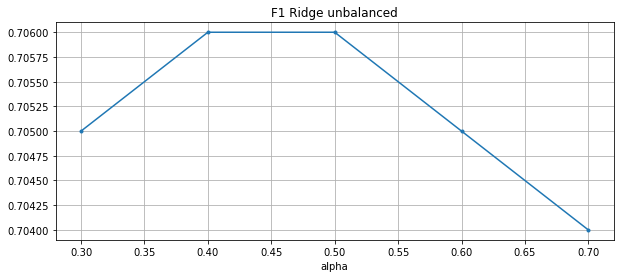

Best F1: 0.706
Best params: {'alpha': 0.4}
Wall time: 1min 3s


In [33]:
%%time
model = RidgeClassifier(random_state=123)
params = {'alpha': np.arange(0.3, 0.8, 0.1)}
paramCV(train_valid, model, params, 'Ridge unbalanced')

Результат Ridge не дотягивает до логистической регрессии и требует больше времени.

#### 2.4 Дерево решений

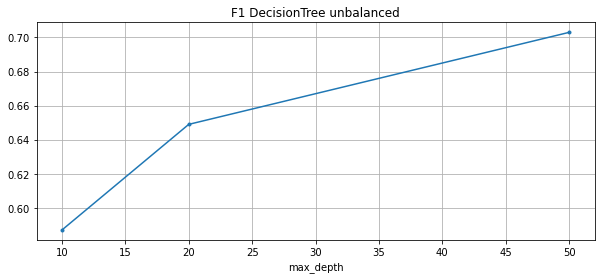

Best F1: 0.703
Best params: {'max_depth': 50}
Wall time: 2min 39s


In [34]:
%%time
model = DecisionTreeClassifier(random_state=123)
params = {'max_depth': [10,20,50]}
paramCV(train_valid, model, params, 'DecisionTree unbalanced')

В прошлых проектах дереву решений было достаточно глубины 5-7, чтобы полностью обучиться, здесь же требуется гораздо более сложная модель. Даже при глубине дерева 100 модель не достигает результата линейной регрессии (F1=0.717) и при этом затрачивает на порядок больше времени. Дальнейшее увеличение глубины дерева и исследование случайного леса считаю нецелесообразным с точки зрения затрачиваемого времени.

## 3. Тестирование

Посмотрим на таблицу с результатами

In [35]:
result_table

,F1
LR unbalanced,0.773
LR balanced,0.762
LR upsampled,0.757
LR downsampled,0.675
SGD unbalanced,0.780
SGD balanced,0.747
SGD upsampled,0.748
Ridge unbalanced,0.706
DecisionTree unbalanced,0.703


Лучший результат показала модель SGD на несбалансированной выборке при alpha=0.000004.

In [36]:
# подготовка признаков обучающей выборки
count_tf_idf = TfidfVectorizer(stop_words=stopwords)
train_corpus = data_train['lemmatized'].values.astype('U')
train_features = count_tf_idf.fit_transform(train_corpus)
train_target = data_train['toxic']
print('train shape', train_features.shape, train_target.shape)

# подготовка признаков тестовой выборки
test_corpus = data_test['lemmatized'].values.astype('U')
test_features = count_tf_idf.transform(test_corpus)
test_target = data_test['toxic']
print('test shape:', test_features.shape, test_target.shape)

model = SGDClassifier(alpha=0.000004, random_state=123)
model.fit(train_features, train_target)
test_predicted = model.predict(test_features)
print('\nFinal model f1 =', f1_score(test_target, test_predicted).round(3))
print(confusion_matrix(test_target, test_predicted))

train shape (127656, 139094) (127656,)
test shape: (31915, 139094) (31915,)

Final model f1 = 0.777
[[28447   315]
 [  952  2201]]


Результат модели на тестовой выборке удовлетворяет требованиям задания (F1 > 0,75). Модель неплохо предсказывает оба типа комментариев, ошибки первого и второго рода встречаются редко.  
Сравним результат с фиктивным классификатором

In [37]:
dummy = DummyClassifier(strategy='stratified')
dummy.fit(train_features, train_target)
dummy_predicted = dummy.predict(test_features)
print('Dummy f1 =', f1_score(test_target, dummy_predicted).round(3))
print(confusion_matrix(test_target, dummy_predicted))

Dummy f1 = 0.105
[[25814  2948]
 [ 2814   339]]


Модель превосходит фиктивный классификатор по всем показателям, что подтверждает ее адекватность.

## Выводы

Работа с текстом требует создания большого количества признаков, что сильно повлияло на результаты исследования.  
Линейные модели, обученные на признаках, составленных с использованием TF-IDF, позволили достигнуть требуемого результата при приемлемом затрачиваемом времени. При этом подбор регуляризации оказался важнее, чем балансировка выборки. Лучший результат был получен с помощью модели SGD на несбалансированной выборке при слабой регуляции (alpha=0.000004), для которой метрика F1 при кросс-валидации составила 0,78.  
Деревянные модели для достижения хорошего результата требуют очень большой глубины, что делает их крайне медленными.  
BERT в данной задаче не позволил достичь требуемого результата, хотя скорее всего дело не в самой модели, а в недостаточном опыте работы с ней.

Выбранная модель SGD была проверена на тестовой выборке, составляющей 20% от исходного датасета. Было получено значение метрики F1 = 0,78, что удовлетворяет условиям задания. Адекватность модели была подтверждена сравнением с фиктивным классификатором.

Можно выделить следующие направления для развития:
- более качественная лемматизация
- алгоритм downsampling, формирующий правильное соотношение обучающей и тестовой (валидационной) выборок 
- использование нейросетей